In [1196]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [1197]:
def load_data():
    """
    Loads training and testing datasets from mnist
    reduces data to only 0,1,2 and returns it.
    """
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    #used for debugging
    '''
    print(type(x_train), x_train.shape, x_train.ndim, x_train.dtype, x_train.itemsize)

    with open('mnist_data.txt', 'w') as f:
        f.write("x_train1: \n" + str(x_train) + "\n")
        f.write("y_train: \n" + str(y_train) + "\n")
        f.write("x_test: \n" + str(x_test) + "\n")
        f.write("y_test: \n" + str(y_test) + "\n")

    print("xtr: ", len(x_train), "ytr: ", len(y_train), "xts: ", len(x_test), len(y_test))
    '''

    train_index = np.isin(y_train, [0, 1])
    #output of above function: [False True ...]
    #print("ms",train_index)
    test_index = np.isin(y_test, [0, 1])

    #reduced data set to only those with digits 0,1
    x_train, y_train = x_train[train_index], y_train[train_index]
    x_test, y_test = x_test[test_index], y_test[test_index]

    # Normalizing to range [0,1]
    x_train = x_train.reshape(-1, 784)
    x_test = x_test.reshape(-1, 784)

    return x_train, y_train, x_test, y_test

def sample_data(x, y, sample_num=1000):
    """
    choose sample_num number of samples randomly and return
    """
    sampled_x, sampled_y = [], []
    for label in [0, 1]:
        indices = np.where(y == label)[0]
        #replace is false so no repetition and 100 samples randomly chosen
        sampled_indices = np.random.choice(indices, sample_num, replace=False)     
        sampled_x.append(x[sampled_indices])
        #sampled_x: [array([0,0,...],uint), array(), array()]
        sampled_y.append(y[sampled_indices])

    return np.vstack(sampled_x), np.concatenate(sampled_y)

def preprocess_data():
    """
    Loads dataset and filters values to 0,1
    Convert images to feature and normalize it. 
    """
    x_train, y_train, x_test, y_test = load_data()
    # sample_x, sample_y = sample_data(x_train, y_train, 200)
    # x_train = np.concatenate([sample_x[0:100], sample_x[200:300], sample_x[400:500]], axis=0)
    # y_train = np.concatenate([sample_y[0:100], sample_y[200:300], sample_y[400:500]], axis=0)

    # x_test = np.concatenate([sample_x[100:200], sample_x[300:400], sample_x[500:600]], axis=0)
    # y_test = np.concatenate([sample_y[100:200], sample_y[300:400], sample_y[500:600]], axis=0)
    x_train, y_train = sample_data(x_train, y_train)
    return x_train, y_train, x_test, y_test


# Step 1: Preprocess Data
x_train, y_train, x_test, y_test = preprocess_data()
print(f'x_train: {x_train.shape}\ny_train: {y_train.shape}\nx_test: {x_test.shape}\ny_test: {y_test.shape}')

x_train: (2000, 784)
y_train: (2000,)
x_test: (2115, 784)
y_test: (2115,)


In [1198]:
def covariance(x_data, x_mean, biased=0):
    x_data-=x_mean
    #print("x_data", (x_data).shape)
    return (1/(len(x_data)-biased))*((x_data.T)@(x_data))

def mean_and_cov(x_train, y_train, biased=0):
    means, covariances = {}, {}

    for c in [0,1,2]:
        x_c = x_train[y_train == c]
        means[c] = np.mean(x_c, axis=0)
        covariances[c] = covariance(x_c, means[c], biased)
        #print("cov: ",covariances[c], len(covariances[c]))

    return means, covariances

### Function used for PCA

def pca(X):
    mean = np.mean(X, axis=1, keepdims=True)
    X_c = X - mean

    covariance = (1/(299))*((X_c)@(X_c.T))
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    
    sorted_idx = np.argsort(eigenvalues)[::-1] #returns sorted indexes.
    eigenvalues, eigenvectors = eigenvalues[sorted_idx], eigenvectors[:, sorted_idx]

    p=5

    # Reduce dimensionality
    U_p = eigenvectors[:, :p]
    Y = (U_p.T@X_c)

    #print("U_p: ", U_p.shape)

    return Y, U_p, mean



Y_pca, U_p, mean_pca = pca(x_train.T)
x_c_test = x_test.T - mean_pca

z_test = (U_p.T)@((x_c_test))

print(Y_pca.shape, z_test.shape)


(5, 2000) (5, 2115)


In [1199]:
class DecisionStump:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.polarity = 1
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)
        feature_values = X[:, self.feature_index]
        if self.polarity == 1:
            predictions[feature_values < self.threshold] = -1
        else:
            predictions[feature_values >= self.threshold] = -1
        return predictions


In [1200]:
def predict_strong(X, classifiers):
    final_pred = np.zeros(X.shape[0])
    for clf in classifiers:
        final_pred += clf.alpha * clf.predict(X)
    return final_pred

In [1201]:
def adaboost(X, y, x_test_pca, y_test_pca, n_rounds=200):
    y = np.where(y == 0, -1, 1)  # Convert labels to {-1, +1}
    val_indices = np.r_[800:1000, 1800:2000]
    train_indices = np.r_[0:800, 1000:1800]

    # Create train/val splits
    x_val = X[val_indices]
    y_val = y[val_indices]
    X = X[train_indices]
    y = y[train_indices]
    n_samples, n_features = X.shape
    w = np.ones(n_samples) / n_samples  # Initial weights
    print(X.shape, x_val.shape, x_test.shape)

    classifiers = []
    train_err = []
    # flag=True
    test_err = []
    loss_train=[]
    loss_test=[]
    loss_val=[]

    for round in range(n_rounds):
        stump = DecisionStump()
        min_error = float('inf')

        # Try all features and 3 thresholds for each
        for feature_i in range(n_features):
            thresholds = np.linspace(X[:, feature_i].min(), X[:, feature_i].max(), 5)[1:-1]
            # print(thresholds)
            for threshold in thresholds:
                for polarity in [1, -1]:
                    pred = np.ones(n_samples)
                    if polarity == 1:
                        pred[X[:, feature_i] < threshold] = -1
                    else:
                        pred[X[:, feature_i] >= threshold] = -1

                    # print("pred", pred)

                    error = np.sum(w[y != pred])/np.sum(w)

                    if error < min_error:
                        min_error = error
                        stump.feature_index = feature_i
                        stump.threshold = threshold
                        stump.polarity = polarity

        stump.alpha = 0.5 * np.log((1 - min_error) / (min_error))
        predictions = stump.predict(X)
        w *= np.exp(-stump.alpha * y * predictions)     #w*e^(alpha) => misclassified , w*e^(-alpha) => correctly classified
        # w /= np.sum(w)

        classifiers.append(stump)

        F_train = predict_strong(X, classifiers)
        # print("F_train: ", F_train)
        F_test  = predict_strong(x_test_pca, classifiers)
        F_val = predict_strong(x_val, classifiers)

        err=np.mean(np.sign(F_train) != y)
        # if (len(train_err)>0):
        #     if (err>train_err[-1]):
        #         flag=False
        # if (flag):
        train_err.append(err)
        test_err.append(np.mean(np.sign(F_test)!= y_test_pca))

        loss_train.append(np.sum(np.exp(-y*F_train)))
        loss_test.append(np.sum(np.exp(-y_test_pca*F_test)))
        loss_val.append(np.sum(np.exp(-y_val*F_val)))
        # loss_train.append(np.mean(np.exp(-y*F_train)))
        # loss_test.append(np.mean(np.exp(-y_test_pca*F_test)))
        # loss_val.append(np.mean(np.exp(-y_val*F_val)))

        if round % 10 == 0:
            print(f"Round {round}, Error: {min_error:.4f}, Alpha: {stump.alpha:.4f}")

    return classifiers, train_err, test_err, loss_train, loss_test, loss_val


In [1202]:
x_train_pca = Y_pca.T
x_test_pca = z_test.T
# Convert y_test to {-1, 1}
y_test_pca = np.where(y_test == 0, -1, 1)

classifiers, train_err, test_err, loss_train, loss_test, loss_val = adaboost(x_train_pca, y_train, x_test_pca, y_test_pca)


test_preds = np.sign(predict_strong(x_test_pca, classifiers))
test_accuracy = np.mean(test_preds == y_test_pca)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


(1600, 5) (400, 5) (2115, 784)
Round 0, Error: 0.0069, Alpha: 2.4865
Round 10, Error: 0.3533, Alpha: 0.3024
Round 20, Error: 0.4282, Alpha: 0.1446
Round 30, Error: 0.4263, Alpha: 0.1485
Round 40, Error: 0.4451, Alpha: 0.1102
Round 50, Error: 0.4502, Alpha: 0.1000
Round 60, Error: 0.4595, Alpha: 0.0811
Round 70, Error: 0.4583, Alpha: 0.0836
Round 80, Error: 0.4716, Alpha: 0.0568
Round 90, Error: 0.4669, Alpha: 0.0664
Round 100, Error: 0.4696, Alpha: 0.0609
Round 110, Error: 0.4791, Alpha: 0.0419
Round 120, Error: 0.4735, Alpha: 0.0530
Round 130, Error: 0.4764, Alpha: 0.0473
Round 140, Error: 0.4827, Alpha: 0.0346
Round 150, Error: 0.4802, Alpha: 0.0396
Round 160, Error: 0.4818, Alpha: 0.0364
Round 170, Error: 0.4816, Alpha: 0.0367
Round 180, Error: 0.4820, Alpha: 0.0359
Round 190, Error: 0.4860, Alpha: 0.0279
Test Accuracy: 99.57%


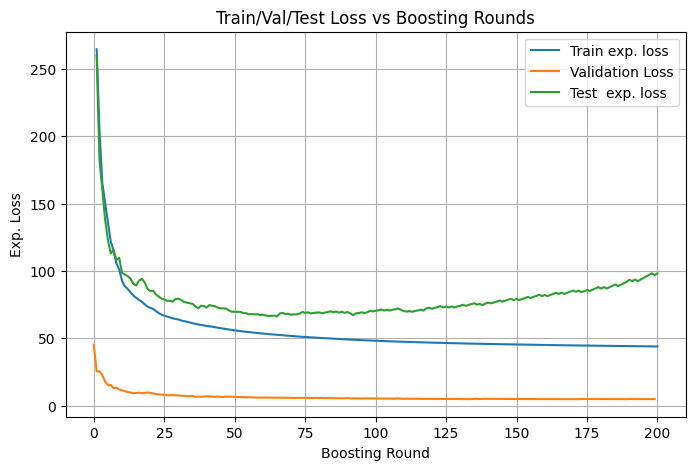

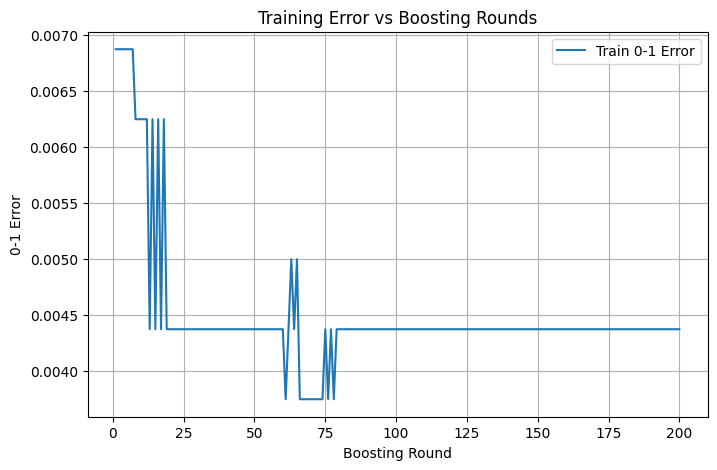

In [1203]:
rounds = np.arange(1, 200+1)

plt.figure(figsize=(8,5))
plt.plot(rounds, loss_train, label="Train exp. loss")
plt.plot(loss_val, label='Validation Loss')
plt.plot(rounds, loss_test, label="Test  exp. loss")
plt.xlabel("Boosting Round")
plt.ylabel("Exp. Loss")
plt.title("Train/Val/Test Loss vs Boosting Rounds")
plt.legend()
plt.grid(True)
# plt.tight_layout()
plt.show()

pt=200
plt.figure(figsize=(8,5))
plt.plot(rounds[:pt], train_err[:pt], label="Train 0-1 Error")
plt.xlabel("Boosting Round")
plt.ylabel("0-1 Error")
plt.title("Training Error vs Boosting Rounds")
plt.legend()
plt.grid(True)
# plt.tight_layout()
plt.show()
